In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ["OMP_NUM_THREADS"] = '1'
import quimb.tensor as qtn

/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/sijingdu/anaconda3/envs/vmc_torch/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
Lx = 10
Ly = 10

In [3]:
peps = qtn.PEPS.rand(Lx, Ly, 2, seed=42)

In [4]:
def delocalize_in_cross(peps, diag=False):

    peps = peps.copy()

    for (i, j) in peps.sites:
        t = peps[i, j]

        if diag:
            neighbors = [
                (i + 1, j + 1),
                (i - 1, j - 1),
                (i + 1, j - 1),
                (i - 1, j + 1),
            ]
        else:
            neighbors = [
                (i + 1, j),
                (i - 1, j),
                (i, j + 1),
                (i, j - 1),
            ]
        for neighbor in neighbors:
            if peps.valid_coo(neighbor):
                t.new_ind(peps.site_ind(neighbor), mode="repeat", size=2)
    return peps

In [5]:
dpeps = delocalize_in_cross(peps, diag=False)

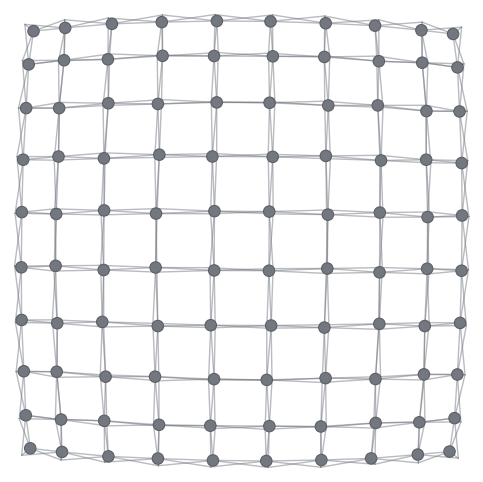

In [6]:
dpeps.draw()

In [7]:
import numpy as np
import torch
peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float64))
max_bond = 10
dummy_config = np.ones((Lx*Ly), dtype=int)
amp = peps.isel({peps.site_inds[i]: int(s) for i, s in enumerate(dummy_config)})
amp.contract()

tensor(-8.1786e-16, dtype=torch.float64)

In [12]:
%%timeit
amp = peps.isel({peps.site_inds[i]: int(s) for i, s in enumerate(dummy_config)})
amp.contract_boundary_from_ymin_(max_bond=max_bond, cutoff=0.0, yrange=[0, peps.Ly//2-1], canonize=True)
amp.contract_boundary_from_ymax_(max_bond=max_bond, cutoff=0.0, yrange=[peps.Ly//2, peps.Ly-1], canonize=True)
amp.contract()

38 ms ± 555 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
from vmc_torch.experiment.tn_model import PEPS_model, PEPS_delocalized_Model

In [16]:
import torch
max_bond = -1
peps.apply_to_arrays(torch.tensor)
dpeps.apply_to_arrays(torch.tensor)
peps_model = PEPS_model(peps, max_bond=max_bond)
dpeps_model = PEPS_delocalized_Model(peps, diag=False, max_bond=max_bond)

/home/sijingdu/TNVMC/VMC_code/quimb/quimb/utils.py:571: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return f(tree)


In [17]:
%%timeit
dummy_config = torch.ones((Lx*Ly), dtype=int)
dpeps_model(dummy_config)

5.53 ms ± 76.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%%timeit
dummy_config = torch.ones((Lx*Ly), dtype=int)
peps_model(dummy_config)

Amplitude computation time: 0.005067999998573214
Amplitude computation time: 0.003851000001304783
Amplitude computation time: 0.004094000003533438
Amplitude computation time: 0.0063630000076955184
Amplitude computation time: 0.00427299999864772
Amplitude computation time: 0.00553899999067653
Amplitude computation time: 0.005132000005687587
Amplitude computation time: 0.003832000002148561
Amplitude computation time: 0.0037569999985862523
Amplitude computation time: 0.004193999993731268
Amplitude computation time: 0.003938000008929521
Amplitude computation time: 0.003647000005003065
Amplitude computation time: 0.003799999991315417
Amplitude computation time: 0.004085999986273237
Amplitude computation time: 0.003941999995731749
Amplitude computation time: 0.004241000002366491
Amplitude computation time: 0.004605999987688847
Amplitude computation time: 0.003895000001648441
Amplitude computation time: 0.004058999998960644
Amplitude computation time: 0.003743000008398667
Amplitude computatio

In [36]:
len(peps_model.from_params_to_vec()), len(dpeps_model.from_params_to_vec())

(2592, 36992)

In [39]:
peps1 = qtn.PEPS.rand(Lx, Ly, 4, seed=42)
peps1.apply_to_arrays(torch.tensor)
peps1_model = PEPS_model(peps1)
len(peps1_model.from_params_to_vec())

3200

In [37]:
test_mlp = torch.nn.Sequential(
    torch.nn.Linear(16, 288),
)
# number of parameters in the test_mlp
sum(p.numel() for p in test_mlp.parameters())

4896